# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Wednesday, March 15, 2023 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). **Make sure you explain your decisions whenever necessary.** 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a customer will cancel the reservation they have made at a hotel. 
For this problem, you will use [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). In this data set, there are about 18.000 examples and 18 features (including the target), and the goal is to estimate whether a person will cancel their booking; this column is labeled "booking_status" in the data (1 = canceled). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

1. Our goal is to predict whether a person will cancel or keep their booking, hence this is a binary classification problem. More specifically, this is a spotting problem where we're interested in spotting if a booking has been canceled (i.e., the positive class). Each row in the dataset corresponds to a specific reservation that was made. Most of the features in the dataset are quantitative. The features that are not quantitative (i.e., categorical or binary) have already been encoded numerically (e.g., `typeofmeal_plan`, `requiredcarparking_space`, `roomtypereserved`, `market_segment_type`, `repeated_guest`).

2. See below:

In [2]:
train_df = pd.read_csv("train__dataset.csv")

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [3]:
df = pd.read_csv("train__dataset.csv")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
X_train = train_df.drop(columns=["booking_status"])
X_test = test_df.drop(columns=["booking_status"])

y_train = train_df["booking_status"]
y_test = train_df["booking_status"]

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

In [4]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12695 entries, 15946 to 15725
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          12695 non-null  int64  
 1   no_of_children                        12695 non-null  int64  
 2   no_of_weekend_nights                  12695 non-null  int64  
 3   no_of_week_nights                     12695 non-null  int64  
 4   type_of_meal_plan                     12695 non-null  int64  
 5   required_car_parking_space            12695 non-null  int64  
 6   room_type_reserved                    12695 non-null  int64  
 7   lead_time                             12695 non-null  int64  
 8   arrival_year                          12695 non-null  int64  
 9   arrival_month                         12695 non-null  int64  
 10  arrival_date                          12695 non-null  int64  
 11  market_segm

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.0000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000
mean,1.851359,0.106892,0.809137,2.202915,0.317290,0.032690,0.338007,85.579913,2017.820402,7.431587,15.743127,0.8000,0.025207,0.022371,0.158724,103.519186,0.625286,0.326113
std,0.515134,0.398709,0.870111,1.419864,0.630232,0.177831,0.775014,87.294409,0.383868,3.084243,8.765916,0.6444,0.156759,0.355431,1.788642,35.370949,0.790905,0.468808
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,16.000000,2018.000000,5.000000,8.000000,0.0000,0.000000,0.000000,0.000000,80.100000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,1.0000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,127.000000,2018.000000,10.000000,23.000000,1.0000,0.000000,0.000000,0.000000,120.600000,1.000000,1.000000
max,4.000000,3.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.0000,1.000000,13.000000,58.000000,375.500000,5.000000,1.000000


There's no missing data, since the non-null count for each features matches the total number of entries in the dataset (12695). However, we do notice that the range of values for the features vary, so we will have to standardize the data. 

Using describe, we can see the mins and maxes for how many people are planning to live in a room, and mean is useful to see the overall average of each feature. Arrival month vs booking status and average price per room vs booking status would be useful visualizations. 

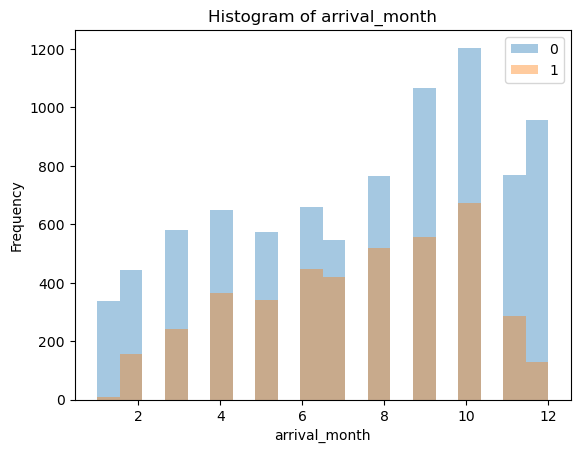

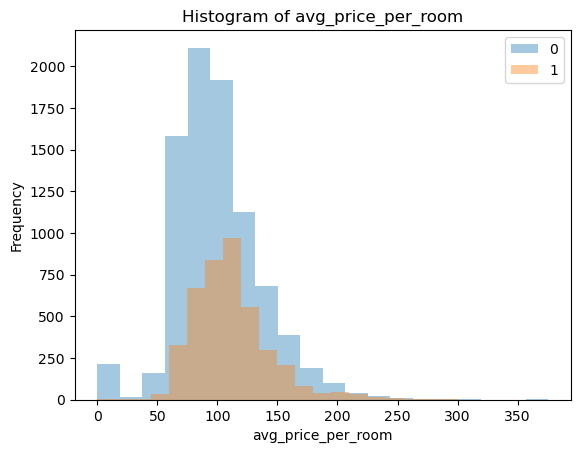

In [5]:
feats = [
    "arrival_month",
    "avg_price_per_room"
]
for feat in feats:
    ax = train_df.groupby("booking_status")[feat].plot.hist(bins=20, alpha=0.4, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

We can see the times of the year where there are the most cancellations, which are October and September. We can also see that when prices are between 100-150, cancellations happen the most often. 

Lastly, we seem to have a class imbalance where there are more bookings cancelled than not cancelled. However, because our ML model will not be making life-threatening decisions (e.g., providing medical diagnosis) and because we don't know which class is more important, we can just not touch the class weights and keep them equal.

In [6]:
booking_counts = train_df['booking_status'].value_counts()
print('% bookings not cancelled: ', booking_counts[0]/len(train_df))
print('% bookings cancelled: ', booking_counts[1]/len(train_df))

% bookings not cancelled:  0.6738873572272548
% bookings cancelled:  0.32611264277274515


Because of the class imbalance, precision and recall are better indicators of our model's peformance, so we can use those alongside F1 score as our metrics for assessment. 

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [7]:
numeric_features = ["no_of_adults", 
                    "no_of_children", 
                    "no_of_week_nights", 
                    "lead_time", 
                    "no_of_previous_cancellations", 
                    "no_of_previous_bookings_not_canceled", 
                    "avg_price_per_room", 
                    "no_of_special_requests"]  

categorical_features = ["type_of_meal_plan", 
                        "arrival_year", 
                        "arrival_month", 
                        "arrival_date", 
                        "market_segment_type"] 

binary_features = ["required_car_parking_space", 
                   "repeated_guest"]  

drop_features = [] 
 
target = "booking_status"

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features),
    (OneHotEncoder(handle_unknown="ignore", drop='if_binary'), binary_features),
    (StandardScaler(), numeric_features),
    ("drop", drop_features)
)


<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [8]:
# We will use strategy='stratified' and f1 as our scoring metric because of the 
# class imbalance we identified in EDA
dummy = DummyClassifier(strategy='stratified')
pd.DataFrame(cross_validate(dummy, 
                            X_train, 
                            y_train, 
                            return_train_score=True, 
                            scoring=['precision', 'recall', 'f1']))

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.001705,0.003715,0.328377,0.328775,0.320048,0.333937,0.324159,0.331336
1,0.001240,0.003021,0.336854,0.323269,0.346618,0.320048,0.341667,0.321651
2,0.001162,0.003097,0.344379,0.323450,0.351449,0.326087,0.347878,0.324763
3,0.001220,0.003086,0.315180,0.308926,0.328502,0.308273,0.321703,0.308599
4,0.001136,0.003058,0.306373,0.331527,0.301932,0.332428,0.304136,0.331976


<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

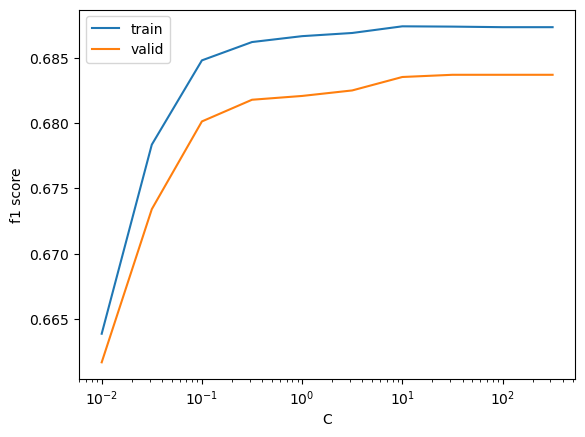

In [9]:
# Hyperparam optimization on logistic regression using f1 score as proxy for precision/recall
# Code borrowed from hw4 q3b

C_vals = 10.0 ** np.arange(-2, 3, 0.5)

train_scores = []
cv_scores = []
train_std = []
cv_std = []

for C in C_vals:
    pipe = make_pipeline(
        preprocessor,
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True, scoring='f1')
    
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())
    train_std.append(cv_results["train_score"].std())
    cv_std.append(cv_results["test_score"].std())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("f1 score");

In [10]:
train_output = []
cv_output = []

for i in range(len(train_scores)):
    train_output.append((f"%0.3f (+/- %0.3f)" % (train_scores[i], train_std[i])))
    cv_output.append((f"%0.3f (+/- %0.3f)" % (cv_scores[i], cv_std[i])))
    
pd.DataFrame({"C": C_vals, 
              "train": train_output, 
              "cv": cv_output})

,C,train,cv
0,0.010000,0.664 (+/- 0.003),0.662 (+/- 0.005)
1,0.031623,0.678 (+/- 0.005),0.673 (+/- 0.005)
2,0.100000,0.685 (+/- 0.003),0.680 (+/- 0.006)
3,0.316228,0.686 (+/- 0.003),0.682 (+/- 0.007)
4,1.000000,0.687 (+/- 0.004),0.682 (+/- 0.007)
5,3.162278,0.687 (+/- 0.005),0.683 (+/- 0.008)
6,10.000000,0.687 (+/- 0.004),0.684 (+/- 0.008)
7,31.622777,0.687 (+/- 0.004),0.684 (+/- 0.008)
8,100.000000,0.687 (+/- 0.004),0.684 (+/- 0.008)
9,316.227766,0.687 (+/- 0.004),0.684 (+/- 0.008)


We don't seem to have an overfitting happening, but our cv score peaks at `C=10` and plateaus.

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

Define `mean_std_cross_val_scores` from lectures:

In [11]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

Score three tree-based ensemble models using their default params:

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Create dict to store models
models = {'LogReg': LogisticRegression(max_iter=1000, C=10),
          'DecTree': DecisionTreeClassifier(),
          'RFC': RandomForestClassifier(), 
          'XGB': XGBClassifier()}

# Initialize empty dict to store output
output = {}

# Cross val on models
for name, model in models.items():    
    pipe = make_pipeline(preprocessor, model)
    cv_results = mean_std_cross_val_scores(pipe, 
                                           X_train, 
                                           y_train, 
                                           return_train_score=True, 
                                           scoring='f1')
    
    output[name] = cv_results
    
pd.DataFrame(output)

,LogReg,DecTree,RFC,XGB
fit_time,0.261 (+/- 0.026),0.076 (+/- 0.002),0.969 (+/- 0.005),1.039 (+/- 0.139)
score_time,0.007 (+/- 0.000),0.007 (+/- 0.000),0.059 (+/- 0.000),0.013 (+/- 0.003)
test_score,0.684 (+/- 0.009),0.762 (+/- 0.007),0.812 (+/- 0.004),0.803 (+/- 0.010)
train_score,0.687 (+/- 0.005),0.995 (+/- 0.000),0.995 (+/- 0.000),0.902 (+/- 0.006)


All the models we used have better CV scores than logistic regression. However, the decision tree and RFC both seem to be significantly overfitting. XGB also seems to be overfitting, but not as bad. Even though XGB's CV score is slightly lower than RFC, I would choose to use XFB because it is overfitting less. 

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

We will use XGBClassifier for this problem. 

In [13]:
# Hyper-param tuning values for param_grid from:
# https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/#:~:text=It%20is%20common%20to%20have,as%20values%20less%20than%200.1.

param_grid = {
    'xgbclassifier__n_estimators': np.arange(50, 1000, 50),
    'xgbclassifier__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}

# Create XGBClassifier pipeline
pipe = make_pipeline(preprocessor, XGBClassifier())

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_grid, 
    scoring='f1',
    random_state=42)

random_search.fit(X_train, y_train)

print(random_search.best_params_)

{'xgbclassifier__n_estimators': 250, 'xgbclassifier__learning_rate': 0.2}


<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

<br><br>

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 